<a href="https://colab.research.google.com/github/gchenfc/RNA_labeling_fluorogenic_photoaffinity/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red-green line similarity

Given data files of image-line data for red intensity and green intensity, calculate the similarity between red/green intensities.

Data files are tab-separated tables with 3 columns: `distance`, `green`, `red`

## Quick Reference Usage Instructions for Google Colab

1. Click here: <a href="https://colab.research.google.com/github/gchenfc/RNA_labeling_fluorogenic_photoaffinity/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
2. On the left-toolbar, click the "folder" icon to bring up the Files menu.
3. In the file-browser, `right click` anywhere -> `New Folder`.  Name it "data"
4. Mouse over "data" folder -> click the 3-dots on the right -> "Upload" -> Select all the files you want to upload (click-shift-click)
5. Edit the OPTIONS below as desired
6. On the top toolbar (File, Edit, View, Insert, ...) Click "Runtime -> Run all"
7. Download "results.zip" (you may need to click the "Refresh" icon in the "Files" left-toolbar)


In [ ]:
# OPTIONS
OUTPUT_DATA_FOLDER_NAME = 'results'
NORMALIZE = True            # Switch this to False if you don't want to normalize
THRESHOLD = 100             # <- this is how you would change noise floorthreshold
EXPORT_IMAGES = False       # Switch this to True if you want to export images of all the plots (slower)

## Setup

In [ ]:
import numpy as np                  # Working with numbers
import pandas as pd                 # Working with tables (optional)
import scipy.stats                  # For statistics (f_oneway is ANOVA)
import matplotlib.pyplot as plt     # Plotting
from pathlib import Path            # Working with filenames and stuff
from dataclasses import dataclass   # Convenience class to hold multiple pieces of data
import itertools                    # For looping over combinations of things

In [ ]:
# Create output folder
Path(OUTPUT_DATA_FOLDER_NAME).mkdir(exist_ok=True)

## Pre-define the equations etc. we will use

In [ ]:
@dataclass
class Linedata:
    '''Linedata is a data object with some common operations built-in'''
    dist: np.ndarray
    green: np.ndarray
    red: np.ndarray

    def normalize(self):
        greenmag = max(self.green.max(), 1e-16)
        redmag = max(self.red.max(), 1e-16)
        return Linedata(
            self.dist.copy(),
            self.green / greenmag,
            self.red / redmag,
        )
    def remove_noise_floor(self, threshold=THRESHOLD, shift=False):
        t = lambda y: (y >= threshold) * (y - threshold if shift else y)
        # t = lambda y: np.maximum(y - threshold, 1e-16) + (0 if shift else threshold)
        return Linedata(
            self.dist.copy(),
            t(self.green),
            t(self.red),
        )

    # Define DK's similarity metric
    def area(self, y):
        return np.trapz(y, self.dist)  # Use trapezoidal rule to calculate area under curve
    def overlap(self):
        return np.minimum(self.green, self.red)
    def intersection(self):  # optional, unused
        return self.overlap()
    def union(self):  # optional, unused
        return np.maximum(self.green, self.red)
    def dk_metric(self):
        O_over_G = self.area(self.overlap()) / max(self.area(self.green), 1e-16) # 0/0 = 0
        O_over_R = self.area(self.overlap()) / max(self.area(self.red), 1e-16) # 0/0 = 0
        return O_over_G, O_over_R

    # Define some other similarity metrics
    def dot_product_similarity(self):
        return np.dot(self.green, self.red)
    def dot_product_cosine_similarity(self):
        return self.dot_product_similarity() / max(
            np.linalg.norm(self.green) * np.linalg.norm(self.red), 1e-16)

    def correlation(self):
        # Actually, this turns out to be equivalent to the dot product when we forbid shifting
        return np.correlate(self.green, self.red)[0]
    def mse(self):
        return np.mean(np.square(self.green - self.red))

## Now run through all the data

In [ ]:
# Load all data
REPLICATE_FOLDER = Path('Rep1')
all_conditions = {}
for REPLICATE_FOLDER in [Path('Rep1'), Path('Rep2')]:
    for condition in range(1, 5):
        folder = REPLICATE_FOLDER / f'Condition{condition}'
        all_conditions[condition] = {}
        for file in Path(folder).iterdir():
            if file.suffix != '.txt':  # Optional: ignore any files that don't end in .txt
                continue
            print(f'processing {str(file)}')
            data = Linedata(*np.loadtxt(file, skiprows=1, encoding=None).T)
            # data.green, data.red = np.abs(data.green), np.abs(data.red)  # Remove negative values
            # data = data.remove_noise_floor(threshold=THRESHOLD)
            # if NORMALIZE:
            #     data = data.normalize()
            all_conditions[condition][REPLICATE_FOLDER / file.name] = data

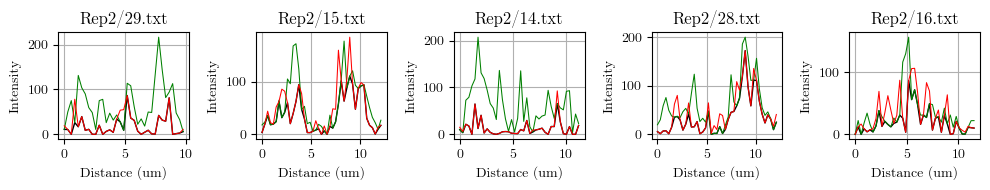

In [ ]:
# Plot as sanity check
def plot(ax, data):
    ax.plot(data.dist, data.overlap(), 'k-', label='overlap', linewidth=1)
    ax.plot(data.dist, data.green, 'g-', label='green', linewidth=0.75)
    ax.plot(data.dist, data.red, 'r-', label='red', linewidth=0.75)
    ax.set_xlabel('Distance (um)')
    ax.set_ylabel('Intensity')
    ax.grid(True)
    # ax.legend()

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for ax, (name, datum) in zip(axes, all_conditions[4].items()):
    plot(ax, datum)
    ax.set_title(name)
fig.tight_layout()

In [ ]:
# Generate images for export
if EXPORT_IMAGES:
  fig, ax = plt.subplots()
  for name, datum in all_data.items():
        ax.cla()
        plot(ax, datum)
        ax.set_title(name)
        fig.savefig((Path(OUTPUT_DATA_FOLDER_NAME) / name).with_suffix('.png'))

In [ ]:
# Calculate all statistics and put them in a table
def create_stats_row(data, condition):
    O_over_G, O_over_R = data.dk_metric()
    return pd.Series({
        'condition': condition,
        'green area': data.area(data.green),
        'red area': data.area(data.red),
        'overlap area': data.area(data.overlap()),
        'O/G': O_over_G,
        'O/R': O_over_R,
        'Cosine Similarity': data.dot_product_cosine_similarity(),
        #'dot product': data.dot_product_similarity(), # this is identical to correlation
        'correlation': data.correlation(),
        'mse': data.mse(),
    })

def create_df(all):
    return pd.DataFrame({
        f'{cond}-{name}': create_stats_row(data, cond) for cond, pairs in all.items()
        for name, data in pairs.items()
    }).transpose()

stats = create_df(all_conditions)
# display(stats)
# display(stats.sort_values(by=['correlation'], ascending=False))  # We can also sort the table
stats.to_excel(Path(OUTPUT_DATA_FOLDER_NAME) / 'stats.xlsx')

In [ ]:
# display histogram of stats
def plot_histograms(stats, column):
    fig, axes = plt.subplots(4, 1, figsize=(6, 4))
    for ax, cond in zip(axes, range(1, 5)):
        ax.hist(stats[stats['condition']==cond][column], bins=np.linspace(0, 1, 20))
        ax.set_ylim(0, 20)
    plt.grid(axis='x')
    axes[0].set_title(f'Histogram of {column}')

# plot_histograms(stats, 'Cosine Similarity')

## Try out some stuff

In [ ]:
def apply_function(func, all_conditions=all_conditions):
    return {
        cond: {name: func(data) for name, data in pairs.items()
              } for cond, pairs in all_conditions.items()
    }
def apply_functions(funcs):
    d = all_conditions
    for func in funcs:
        d = apply_function(func, d)
    return d
def custom_normalization(linedata, greennorm=np.max, rednorm=np.max, red_usegreen=False):
    greenmag = max(greennorm(linedata.green), 1e-16)
    redmag = max(rednorm(linedata.green if red_usegreen else linedata.red), 1e-16)
    return Linedata(
        linedata.dist.copy(),
        linedata.green / greenmag,
        linedata.red / redmag,
    )

def print_anova_header():
    print('ANOVA p values:')
    for conditions in itertools.combinations(range(1, 5), 2):
        print(f'{conditions[0]} vs {conditions[1]}', end='  ')
    print()
    print('------  ' * 6)
def calc_anova(stats, column):
    return [
        scipy.stats.f_oneway(stats[stats["condition"] == conditions[0]][column],
                             stats[stats["condition"] == conditions[1]][column]).pvalue
        for conditions in itertools.combinations(range(1, 5), 2)
    ]
def print_anova(stats, column, suffix=''):
    for p in calc_anova(stats, column):
        print(f'{p:.04f}', end='  ')
    print(suffix)

def create_anova_array(all_funcs, columns):
    rows = []
    for funcs in all_funcs:
        for column in columns:
            rows.append(calc_anova(create_df(apply_functions(funcs)), column))
    labels = [f'{c0} vs {c1}' for c0, c1 in itertools.combinations(range(1, 5), 2)]
    return labels, rows
def create_anova_heatmap(all_funcs, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(10, 1+0.3*len(all_funcs)))
    for ax, column in zip(axes, columns):
        labels, rows = create_anova_array(all_funcs, [column])
        ax.imshow(rows, cmap='gray', vmin=0, vmax=0.05)
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=90)
        ax.set_yticks(range(len(all_funcs)))
        # ax.set_yticklabels([f.__name__ for f in all_funcs])
        ax.set_xlabel('Condition Pair')
        ax.set_ylabel('Preprocessing Configuration')
        ax.set_title(column)
        ax.grid(False)

        rows = np.array(rows)
        for y in range(rows.shape[0]):
            for x in range(rows.shape[1]):
                ax.text(x, y, '%.4f' % rows[y, x],
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='red',
                        size=8,
                        rotation=30,
                        )
    fig.suptitle('ANOVA p-values')
    fig.tight_layout()
    return fig, ax

def apply_funcs_and_print_anova(funcs, column):
    print_anova(create_df(apply_functions(funcs)), column, suffix=column)
def apply_func_and_plot_hist(funcs, column):
    plot_histograms(create_df(apply_functions(funcs)), column)
def apply_func_and_plot_violin(ax, funcs, column):
    plot_violin(ax, create_df(apply_functions(funcs)), column)

def plot_violin(ax, stats, column):
    if ax is None:
        _, ax = plt.subplots(figsize=(3, 3))
    # fig, axes = plt.subplots(4, 1, figsize=(6, 4))
    dat = [stats[stats['condition']==cond][column] for cond in range(1, 5)]
    # ax.violinplot(dat, showmeans=True, showextrema=True, showmedians=True)
    ax.violinplot(dat, showmeans=True, showextrema=False, showmedians=False)
    ax.set_xticks(range(1, 5))
    plt.grid(axis='x')
    ax.set_xlabel('Condition')
    # ax.set_ylabel(column)
    if column == 'mse':
        column = 'MSE (lower is better)'
    ax.set_title(f'{column}')

# print_anova_header()
# print_anova(stats, 'Cosine Similarity')
# plot_histograms(stats, 'Cosine Similarity')
# plot_violin(None, stats, 'Cosine Similarity')

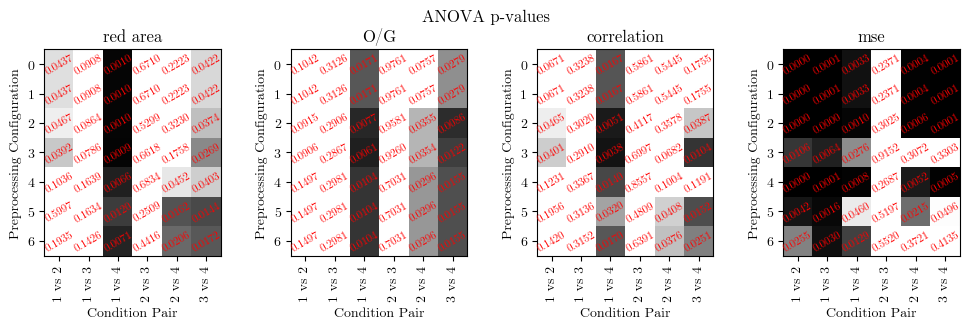

In [ ]:
metrics = [
    # 'green area',
    'red area',
    # 'overlap area',
    'O/G',
    # 'O/R',
    # 'Cosine Similarity',
    # 'dot product', # Identical to correlation
    'correlation',
    'mse',
]

floor1 = Linedata.remove_noise_floor
floor2 = lambda x: Linedata.remove_noise_floor(x, shift=True)
norm1 = Linedata.normalize
rms = lambda x: np.sqrt(np.mean(np.square(x)))
norm21 = lambda x: custom_normalization(x, greennorm=np.max, rednorm=np.max, red_usegreen=False)
norm22 = lambda x: custom_normalization(x, greennorm=np.mean, rednorm=np.mean, red_usegreen=False)
norm23 = lambda x: custom_normalization(x, greennorm=rms, rednorm=rms, red_usegreen=False)
norm31 = lambda x: custom_normalization(x, greennorm=np.max, rednorm=np.max, red_usegreen=True)
norm32 = lambda x: custom_normalization(x, greennorm=np.mean, rednorm=np.mean, red_usegreen=True)
norm33 = lambda x: custom_normalization(x, greennorm=rms, rednorm=rms, red_usegreen=True)
preprocessing_options = [
    # [floor1, norm1],  #0
    [floor2, norm1],   #0 (DK's current version, should be the same as 1, but just sanity check)
    [floor2, norm21],  #1
    [floor1, norm21],  #2
    # [floor1, norm22],  #3
    [floor1, norm23],  #4
    [floor1, norm31],  #5
    [floor1, norm32],  #6
    # [floor1, norm32],  #6
    [floor1, norm33],  #7
]

# print_anova_header()
# for ax_rows, funcs in zip(axes, preprocessing_options):
#     for ax, metric in zip(ax_rows, metrics):
#         apply_funcs_and_calc_anova(funcs, metric)
create_anova_heatmap(preprocessing_options, metrics)

# Create violin plots
fig, axes = plt.subplots(
                         len(metrics),
    len(preprocessing_options),
                        #  figsize=(10, 2 * len(preprocessing_options)))
                         figsize=(2 * len(preprocessing_options), 10))
fig.suptitle('Violin Plots\n(Each column is a different preprocessing configuration)')

for ax_rows, funcs in zip(axes.T, preprocessing_options):
    for ax, metric in zip(ax_rows, metrics):
        apply_func_and_plot_violin(ax, funcs, metric)
fig.tight_layout()

# Plot line intensities before/after preprocessing for debugging

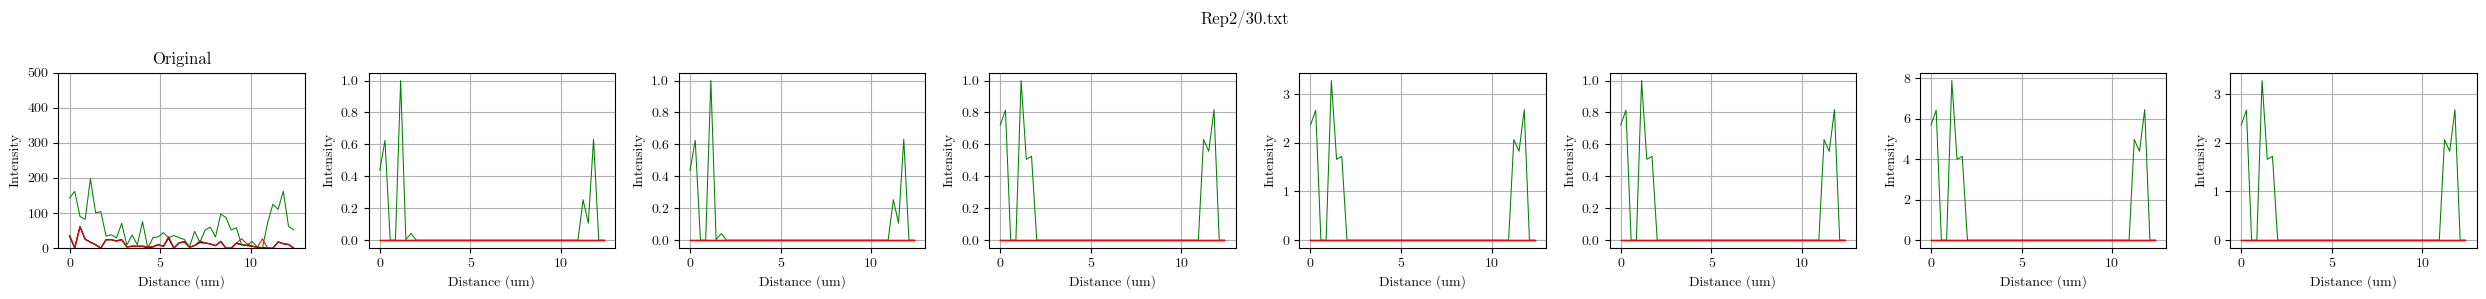

In [ ]:
# Generate images for export
# if EXPORT_IMAGES:
if True:
    fig, axes = plt.subplots(1, len(preprocessing_options) + 1, figsize=(25, 3))
    for cond in range(1, 5):
        folder = Path(OUTPUT_DATA_FOLDER_NAME) / f'Condition{cond}'
        folder.mkdir(parents=True, exist_ok=True)
        for name, datum in all_conditions[cond].items():
            axes[0].cla()
            plot(axes[0], datum)
            axes[0].set_title('Original')
            axes[0].set_ylim(0, 500)
            for ax, funcs in zip(axes[1:], preprocessing_options):
                d = datum
                for func in funcs:
                    d = func(d)
                ax.cla()
                plot(ax, d)
                # ax.set_ylim(0, 3)
            fig.suptitle(name)
            fig.tight_layout()
            fig.savefig((folder / '-'.join(name.parts)).with_suffix('.png'))

In [ ]:
!cd results && ./stack_images.sh

## Compress results into a zip folder

In [ ]:
!zip -r results.zip results